In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, VBox, HBox, interactive_output
from utils import create_slider, get_slider_values
from torch import Tensor
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from botorch.utils.transforms import normalize, unnormalize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
from matplotlib import pyplot as plt
from botorch.acquisition import ExpectedImprovement

dtype = torch.double

## Example - Enzyme Cascade

$$
P(E) = 
\sum_{i=1}^N \left( (-1)^{i+1} \cdot P_{\text{max},i} \cdot \frac{\left(\frac{E}{s}\right)^{n_i}}{K_i^{n_i} + \left(\frac{E}{s}\right)^{n_i}} \right) 
- I \cdot \frac{\left(\frac{E}{s}\right)^2}{\left(\frac{E}{s}\right)^2 + K_I^2}
$$

### Tune ground truth to your heart's content

In [ ]:
# Function for plotting
def enzyme_truth(
    x, p_max1, k1, n1, p_max2, k2, n2, p_max3, k3, n3, p_max4, k4, n4, i, k_I, s
):
    """
    True relation of enzyme concentration to productivity.
    Parameters
    ----------
    x : float
        Enzyme concentration.
    Returns
    -------
    p : float
        Productivity.
    """
    x_scaled = x / s
    p1 = p_max1 * (x_scaled**n1 / (k1**n1 + x_scaled**n1))
    p2 = p_max2 * (x_scaled**n2 / (k2**n2 + x_scaled**n2))
    p3 = p_max3 * (x_scaled**n3 / (k3**n3 + x_scaled**n3))
    p4 = p_max4 * (x_scaled**n4 / (k4**n4 + x_scaled**n4))
    inhibition = i * (x_scaled**2 / (x_scaled**2 + k_I**2))
    return p1 - p2 + p3 - p4 - inhibition


def plot_enzyme_truth(
    p_max1, k1, n1, p_max2, k2, n2, p_max3, k3, n3, p_max4, k4, n4, i, k_I, s
):
    x = np.linspace(0, 90, 500)
    plt.figure(figsize=(10, 6))
    plt.plot(
        x,
        enzyme_truth(
            x, p_max1, k1, n1, p_max2, k2, n2, p_max3, k3, n3, p_max4, k4, n4, i, k_I, s
        ),
        label="Productivity",
        color="blue",
    )
    plt.title("Interactive Parameter Selection with Grouped Layout")
    plt.xlabel("Enzyme Concentration [mg mL$^{-1}$]")
    plt.ylabel("Productivity [mmol L$^{-1}$ h$^{-1}$]")
    plt.grid()
    plt.show()


# Sliders
p_max1_slider = create_slider(10, 100, 1, 38, "p_max1")
k1_slider = create_slider(1, 20, 0.5, 8, "k1")
n1_slider = create_slider(1, 10, 0.1, 2, "n1")

p_max2_slider = create_slider(10, 50, 1, 26, "p_max2")
k2_slider = create_slider(10, 50, 1, 20, "k2")
n2_slider = create_slider(1, 10, 0.1, 6, "n2")

p_max3_slider = create_slider(10, 100, 1, 80, "p_max3")
k3_slider = create_slider(20, 50, 1, 34, "k3")
n3_slider = create_slider(1, 10, 0.1, 4, "n3")

p_max4_slider = create_slider(10, 100, 1, 71, "p_max4")
k4_slider = create_slider(40, 90, 1, 57, "k4")
n4_slider = create_slider(1, 10, 0.1, 6, "n4")

inhibition_slider = create_slider(10, 150, 1, 72, "Inhibition")
k_I_slider = create_slider(1, 100, 0.1, 35, "k_I")
stretch_slider = create_slider(0.1, 5, 0.1, 1.7, "Stretch")

sliders = {
    "p_max1": p_max1_slider,
    "k1": k1_slider,
    "n1": n1_slider,
    "p_max2": p_max2_slider,
    "k2": k2_slider,
    "n2": n2_slider,
    "p_max3": p_max3_slider,
    "k3": k3_slider,
    "n3": n3_slider,
    "p_max4": p_max4_slider,
    "k4": k4_slider,
    "n4": n4_slider,
    "i": inhibition_slider,
    "k_I": k_I_slider,
    "s": stretch_slider,
}

# Arrange sliders in groups
group1 = VBox([p_max1_slider, k1_slider, n1_slider])
group2 = VBox([p_max2_slider, k2_slider, n2_slider])
group3 = VBox([p_max3_slider, k3_slider, n3_slider])
group4 = VBox([p_max4_slider, k4_slider, n4_slider])
global_controls = VBox([inhibition_slider, k_I_slider, stretch_slider])
controls = VBox([HBox([group1, group2, group3, group4]), global_controls])


# Interactive widget without duplicating sliders
widget = interactive_output(
    plot_enzyme_truth,
    {
        "p_max1": p_max1_slider,
        "k1": k1_slider,
        "n1": n1_slider,
        "p_max2": p_max2_slider,
        "k2": k2_slider,
        "n2": n2_slider,
        "p_max3": p_max3_slider,
        "k3": k3_slider,
        "n3": n3_slider,
        "p_max4": p_max4_slider,
        "k4": k4_slider,
        "n4": n4_slider,
        "i": inhibition_slider,
        "k_I": k_I_slider,
        "s": stretch_slider,
    },
)

# Display the custom layout and plot output
display(controls, widget)

Output()

### Continue with newly created ground truth

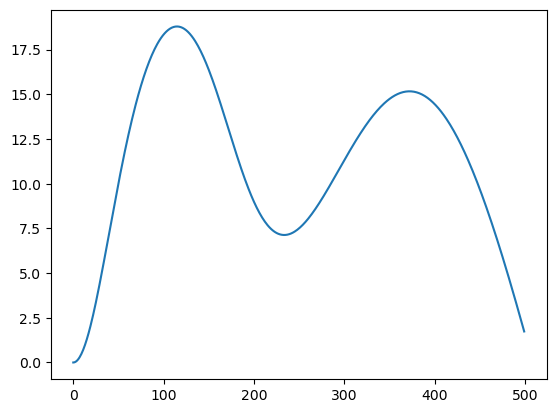

In [3]:
selected_params = get_slider_values(sliders)

x = np.linspace(0, 90, 500)
plt.plot(enzyme_truth(x, **selected_params))